In [151]:
import os, sys, pickle
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
import jp_mpl as jplot
import pickle, scipy
from copy import deepcopy
from scipy import optimize

## Fitting class

In [152]:
class FitLBpos(object):
    def __init__(self,
                 data = None,
                 error = None,
                 pmt_xyz = None,
                 pmtbool = None,
                 psup_radius = 8390.,
                 water_n = 1.34389,
                 print_call = True):
        self.c            = 0.299792458*1000 # mm/ns
        self.data    = deepcopy(data)
        self.pmt_xyz = deepcopy(pmt_xyz)
        self.pmtbool = deepcopy(pmtbool)
        self.pmt_r   = np.linalg.norm(pmt_xyz,axis=1)
        self.header_done = False

        self.R = psup_radius
        #self.water_c = c/water_n
        self.print_call = print_call
        
        self.pmtbool[self.data == 0] = False
        
        if error == None:
            self.error = np.ones_like(data)
        else:
            self.error = error + 1 # Adding one ns for everything
    
    def print_eval_header(self):
        print 'FCN \t\t u \t v \t w \t n'
        self.header_done = True
        
    def print_eval(self, value, u, v, w, n):
        if not self.header_done:
            self.print_eval_header()
        print value, '\t', u, '\t', v, '\t', w, '\t', n
        
    def __call__(self, u, v, w, n):
        this_pos = np.array([ u, v, w])
        water_c = self.c/n
        tdiff = 2*self.R/water_c* \
                (1+np.dot(self.pmt_xyz,this_pos)/(self.pmt_r*self.R))
        
        delta = (tdiff - self.data)[self.pmtbool]**2/self.error[self.pmtbool]**2
        delta = np.sum(delta)
        
        if self.print_call:
            self.print_eval(delta, u, v, w, n)
        
        return delta

## PMT Information

In [153]:
pmt_info = pickle.load(open('/home/jpyanez/snoplus/snoplus_python/pmt_positions.pckl'))
typebool = (pmt_info['type'] == 1) + (pmt_info['type']==7)

In [154]:
quality_dir = '/home/jpyanez/snoplus/data/laserball_quality'

## Speed of light

In [155]:
c = 0.299792458*1000 # mm/ns, same as in Geant4

## Getting SOC files - produce peaks files first

In [156]:
peakdir = '/home/jpyanez/snoplus/data/SOC_peak_files'

In [157]:
infile_list = [x for x in os.listdir(peakdir) if os.path.isfile(os.path.join(peakdir,x))]
for i, x in enumerate(infile_list): print i, x 

0 SOC_0000017375.pckl
1 SOC_0000100556.pckl
2 SOC_0000100558.pckl
3 SOC_0000101427.pckl
4 SOC_0000101428.pckl
5 SOC_0000101432.pckl
6 SOC_0000101433.pckl
7 SOC_0000102518.pckl
8 SOC_0000102529.pckl
9 SOC_0000102552.pckl
10 SOC_0000102554.pckl
11 SOC_0000102570.pckl
12 SOC_0000102572.pckl
13 SOC_0000102574.pckl


# Fit everything!

In [164]:
use_quality_cuts = False
use_peak = False # False means using dN/dt
if use_peak:
    data_index = 0
else:
    data_index = 1

In [165]:
np.sum(pmt_q_bool)

9728

In [167]:
fit_values = np.zeros([len(infile_list), 4])
manip_values = np.zeros([len(infile_list), 3])
socfit_values = np.zeros_like(manip_values)
average_occ   = np.zeros(len(infile_list))
average_occ_all = np.zeros_like(average_occ)
for i, one_run in enumerate(infile_list):
    
    print 'Starting run', one_run
    
    # Get the data
    data = pickle.load(open(os.path.join(peakdir, one_run)))
    
    # Get the PMT quality
    if use_quality_cuts:
        pmtq_fname = os.path.join(quality_dir, one_run.rstrip('.pckl') + '_PMT_quality.pckl')
        pmtq_file = open(pmtq_fname)
        pmtq = pickle.load(pmtq_file)
        pmtq_file.close()
        
    # Select the PMTs that should be included in the fit
    socpmts  = np.zeros_like(pmt_info['type'],dtype=bool)
    socpmts[data['soc_pmts']] = True
    nonzero_peaks = (data['delta_ts'][:,0] > 0)*(data['delta_ts'][:,1] > 0)
    mypmtbool = np.array(typebool*socpmts*nonzero_peaks,dtype=bool)

    
    if use_quality_cuts:
        pmt_q_bool = (pmtq['positive']*pmtq['global_cut']*pmtq['normal_pmts']*
                      pmtq['nearby_cut']*pmtq['unobstructed'])
    else:
        pmt_q_bool = np.ones_like(mypmtbool)
        #pmt_q_bool = (pmtq['positive']*pmtq['unobstructed'])
        

    lbfit = FitLBpos( data = data['delta_ts'][:,data_index],
                      error = np.abs(data['delta_ts'][:,0]-data['delta_ts'][:,1]),
                      pmt_xyz = pmt_info['xyz'],
                      pmtbool = mypmtbool*pmt_q_bool,
                      print_call = False)
    
    print 'PMTs in the fit', np.sum(lbfit.pmtbool)

    
    wrapfcn = lambda p: lbfit(*p)
    repeat_fit = True
    
    average_occ[i] = data['poccupancy'][lbfit.pmtbool*~np.isnan(data['poccupancy'])].mean()
    average_occ_all[i] = data['poccupancy'][data['poccupancy']>0.].mean()
    
    fit_counter = 0
    while repeat_fit:
        my_x0 = np.concatenate((data['fit_pos']*(1+np.random.rand(3)/10.), [1.3]))
        fit = optimize.minimize(wrapfcn,
                                  x0 = my_x0,
                                  method='SLSQP',
                                  bounds=((-6500,6500),
                                          (-6500,6500),
                                          (-6500,6500),
                                          (0.5, 2.)),
                                  options={'ftol':1E-7, 'maxiter':1000})
        fit_counter += 1
        if fit.success:
            repeat_fit = False
            fit_values[i, : ] = fit.x
            print '\nFit successful', one_run.rstrip('.pckl')
            print data['manip_pos']
            print data['fit_pos']
            print fit.x, '\n'
            manip_values[i,:] = data['manip_pos']
            socfit_values[i,:] = data['fit_pos']
        else:
            print 'Trying again', fit_counter
            if fit_counter >= 10:
                print 'Tried to fit TEN times without success - check that'
                fit_values[i,:] = [-1]*4
                repeat_fit = False
                
        
    
    

Starting run SOC_0000017375.pckl
PMTs in the fit 8666
Trying again 1
Trying again 2
Trying again 3
Trying again 4

Fit successful SOC_0000017375
[   0. -254.   25.]
[   0.24428572 -226.06359863   23.39888954]
[   5.72648664 -225.92315638  -21.27683212    1.34286238] 

Starting run SOC_0000100556.pckl
PMTs in the fit 8311
Trying again 1

Fit successful SOC_0000100556
[   0. -254.   25.]
[   3.82698131 -207.07707214   24.78620338]
[  -0.4222418  -214.7128939    -5.39609767    1.36361971] 

Starting run SOC_0000100558.pckl
PMTs in the fit 8316

Fit successful SOC_0000100558
[   0. -254.   25.]
[   6.7621541  -208.42858887   26.4679184 ]
[  -1.0662136  -233.34347538    3.80489529    1.35554063] 

Starting run SOC_0000101427.pckl
PMTs in the fit 7946

Fit successful SOC_0000101427
[   0. -254.   25.]
[ -20.76714706 -224.04202271   15.78341579]
[-141.24503297   55.51353952  693.2448581     1.27947925] 

Starting run SOC_0000101428.pckl
PMTs in the fit 8601

Fit successful SOC_0000101428
[   

/gs/software/CentOS-6/eb/software/Toolchain/iomkl/2015b/IPython/3.2.1-Python-2.7.10/lib/python2.7/site-packages/IPython/kernel/__main__.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [168]:
# Figure out who has the maximum occupancy
average_occ[np.isnan(average_occ)] = 0.

In [169]:
run_list = []
for i, fname in enumerate(infile_list):
    print fname.rstrip('.pckl').rstrip('_reprocessed'), '\t', '\t'.join(["%0.4f" % x for x in fit_values[i,:]])
    run_list.append(fname.lstrip('SOC_0000').rstrip('.pckl').rstrip('_newPCA').rstrip('_reprocessed'))

SOC_0000017375 	5.7265	-225.9232	-21.2768	1.3429
SOC_0000100556 	-0.4222	-214.7129	-5.3961	1.3636
SOC_0000100558 	-1.0662	-233.3435	3.8049	1.3555
SOC_0000101427 	-141.2450	55.5135	693.2449	1.2795
SOC_0000101428 	-3.0254	-225.7677	-19.3651	1.3533
SOC_0000101432 	-0.0729	-226.8463	-19.0670	1.3661
SOC_0000101433 	-14.0217	-246.4081	127.5762	1.3403
SOC_0000102518 	-2.8576	-225.8370	-0.7951	1.3490
SOC_0000102529 	-2.4595	-223.7262	-10.0969	1.3639
SOC_0000102552 	-231.2158	197.7581	808.5785	1.1548
SOC_0000102554 	-2.7662	-257.7550	0.7348	1.3573
SOC_0000102570 	-1.0000	-1.0000	-1.0000	-1.0000
SOC_0000102572 	-24.4439	-75.5238	1893.7460	1.2348
SOC_0000102574 	-7.8732	-188.9402	-6.5518	1.3717


(-0.5, 14.5)

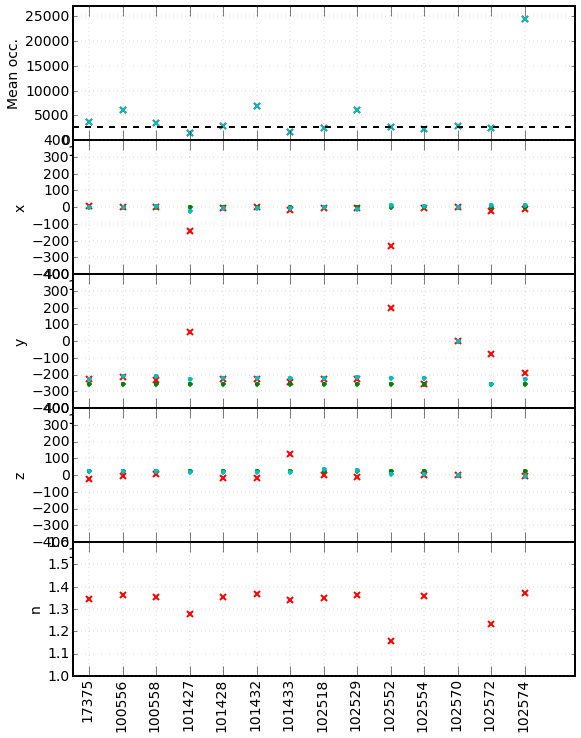

In [170]:
fig = plt.figure(figsize=(9,12))
axes = []

axes.append(fig.add_subplot(511))

plt.xlabel('Run')

plt.plot(average_occ, 'xr')
plt.plot(average_occ_all, 'xc')
plt.ylim([0, average_occ.max()*1.1])
plt.axhline(y=2700, xmin = 0, xmax=len(run_list), color = 'k', linestyle = '--')

plt.ylabel('Mean occ.')
for i, value_name in enumerate(['x', 'y', 'z', 'n']):
    axes.append(fig.add_subplot(5, 1, i+2, sharex=axes[0]))
    plt.ylabel(value_name)
    plt.plot(fit_values[:,i], 'xr')
    if i < 3:
        plt.plot(manip_values[:,i], '.g')
        plt.plot(socfit_values[:,i], '.c')
        plt.ylim(-400, 400)
    if i == 3:
        plt.ylim([1.0, 1.6])
plt.subplots_adjust(hspace = 0.)
axes[-1].set_xticks(range(0, len(run_list)))
axes[-1].set_xticklabels(run_list,rotation=90)
axes[-1].set_xlim(-0.5, len(run_list)+0.5)